In [56]:
import pyxdf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
XDF_FILE = "1_17_26.xdf"   # path to your xdf file

# ==========================
# LOAD XDF
# ==========================
streams, header = pyxdf.load_xdf(XDF_FILE)

print(f"Loaded {len(streams)} streams")

# Sort streams by name for consistent ordering
streams = sorted(streams, key=lambda s: s['info']['name'][0])
streams

Stream 1: Calculated effective sampling rate 633.3790 Hz is different from specified rate 1000.0000 Hz.


Loaded 4 streams


[{'info': defaultdict(list,
              {'name': ['ECG_Stream'],
               'type': ['ECG'],
               'channel_count': ['1'],
               'channel_format': ['float32'],
               'source_id': ['ecg_serial_001'],
               'nominal_srate': ['1000.000000000000'],
               'version': ['1.100000000000000'],
               'created_at': ['74306.94393720001'],
               'uid': ['1b0e516b-082f-4478-abfd-a9ffef824fe3'],
               'session_id': ['default'],
               'hostname': ['Sanjayra'],
               'v4address': [None],
               'v4data_port': ['16591'],
               'v4service_port': ['16599'],
               'v6address': [None],
               'v6data_port': ['16591'],
               'v6service_port': ['16599'],
               'desc': [defaultdict(list,
                            {'channels': [defaultdict(list,
                                          {'channel': [defaultdict(list,
                                                

633.3790152413895
ECG_Stream: (380028, 1), 1000.0 Hz
24.986233112487646
PPG_GRN: (14992, 1), 25.0 Hz
24.986232443444994
PPG_IR: (14992, 1), 25.0 Hz
24.986232547940364
PPG_RED: (14992, 1), 25.0 Hz


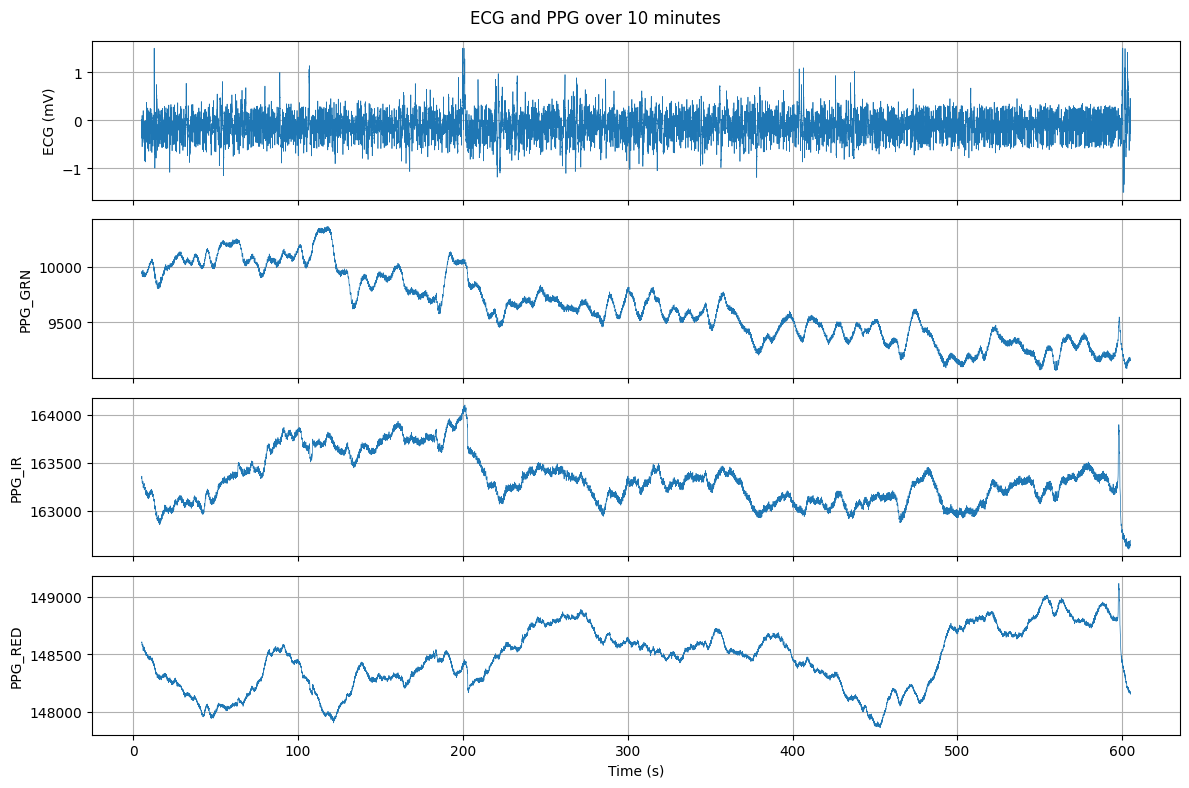

In [76]:
fig, axes = plt.subplots(len(streams), 1, sharex=True, figsize=(12, 8))

if len(streams) == 1:
    axes = [axes]  # handle edge case

for idx, stream in enumerate(streams):
    name = stream['info']['name'][0]
    srate = float(stream['info']['nominal_srate'][0])

    data = np.array(stream['time_series'])
    timestamps = np.array(stream['time_stamps']) - stream['time_stamps'][0]  # normalize to start at 0
    print(1.0 / np.mean(np.diff(timestamps)))
    mask = (5 <= timestamps) & (timestamps <= 605)
    timestamps = timestamps[mask]
    data = data[mask]

    if name == "ECG_Stream":
        # For ECG, convert to mV assuming 12-bit ADC, 3.3V reference and gain of 1100
        data = (((data / 4096 * 3.3) - (3.3 / 2)) / 1100) * 1000
    
    print(f"{name}: {data.shape}, {srate} Hz")

    # If multichannel, plot first channel (change if needed)
    if data.ndim > 1:
        data = data[:, 0]

    axes[idx].plot(timestamps, data, linewidth=0.5)
    axes[idx].set_ylabel("ECG (mV)" if name == "ECG_Stream" else name)
    axes[idx].grid(True)

axes[-1].set_xlabel("Time (s)")

plt.suptitle("ECG and PPG over 10 minutes")
plt.tight_layout()
plt.show()

In [85]:
import neurokit2 as nk

def estimate_fs(timestamps):
    return 1.0 / np.mean(np.diff(timestamps))

def select_time_window(t, x, t_start, t_end):
    """Select a time window from t_start to t_end."""
    mask = (t >= t_start) & (t <= t_end)
    return t[mask], x[mask]

def find_peaks(signal, timestamps, signal_type="ecg"):
    """Clean signal and detect peaks using NeuroKit2."""
    fs = 1000 if signal_type == "ecg" else 25 # estimate_fs(timestamps)

    if signal_type == "ecg":
        cleaned = nk.ecg_clean(signal, sampling_rate=fs)
        peaks, info = nk.ecg_peaks(cleaned, sampling_rate=fs)
        # peaks is a DataFrame column: 1 where a peak exists
        peak_times = timestamps[peaks['ECG_R_Peaks'].values.astype(bool)]
    elif signal_type == "ppg":
        cleaned = nk.ppg_clean(signal, sampling_rate=fs)
        peaks, info = nk.ppg_peaks(cleaned, sampling_rate=fs)
        peak_times = timestamps[peaks['PPG_Peaks'].values.astype(bool)]
    else:
        raise ValueError("signal_type must be 'ecg' or 'ppg'")

    return cleaned, peak_times

def compute_hr_hrv(signal, timestamps, signal_type):
    """
    signal_type: "ecg" or "ppg"
    """
    fs = estimate_fs(timestamps)

    if signal_type == "ecg":
        cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="pantompkins1985")
        peaks, info = nk.ecg_peaks(cleaned, sampling_rate=fs, correct_artifacts=True, show=True)
        rate = nk.ecg_rate(peaks, sampling_rate=fs)

    elif signal_type == "ppg":
        cleaned = nk.ppg_clean(signal, sampling_rate=fs)
        peaks, info = nk.ppg_peaks(cleaned, sampling_rate=fs)
        rate = nk.ppg_rate(peaks, sampling_rate=fs)

    else:
        raise ValueError("signal_type must be 'ecg' or 'ppg'")

    # HRV metrics from detected peaks
    hrv = nk.hrv(peaks, sampling_rate=fs, show=False)

    return {
        "fs": fs,
        "cleaned": cleaned,
        "peaks": peaks,
        "rate": rate,
        "hrv": hrv
    }

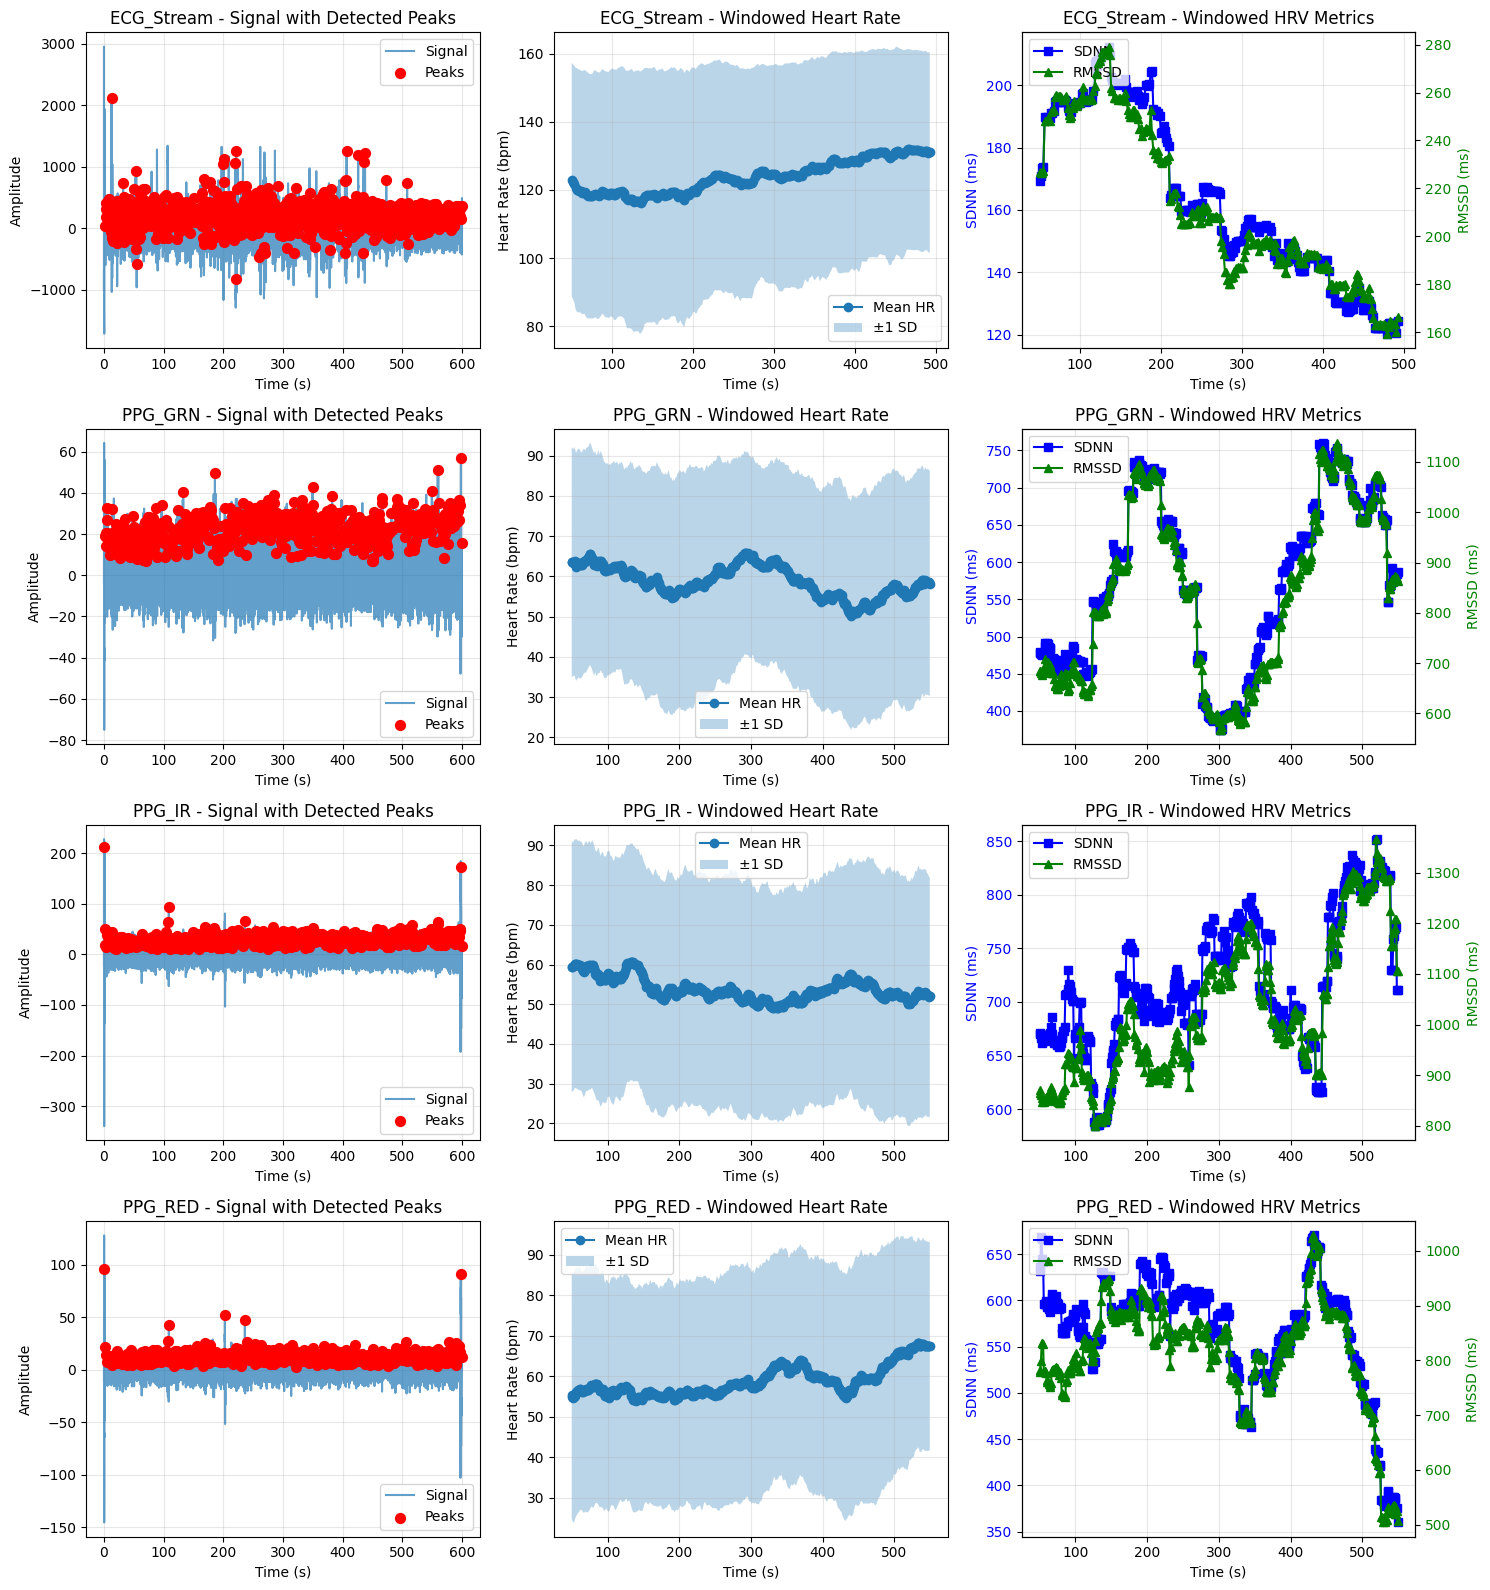


=== Summary Statistics ===

ECG_Stream:
  Mean HR: 123.8 ± 4.7 bpm
  Mean SDNN: 163.6 ± 27.2 ms
  Mean RMSSD: 212.5 ± 33.2 ms

PPG_GRN:
  Mean HR: 58.8 ± 3.7 bpm
  Mean SDNN: 574.2 ± 112.5 ms
  Mean RMSSD: 840.6 ± 172.5 ms

PPG_IR:
  Mean HR: 53.9 ± 2.9 bpm
  Mean SDNN: 717.8 ± 61.3 ms
  Mean RMSSD: 1027.9 ± 140.9 ms

PPG_RED:
  Mean HR: 58.8 ± 3.6 bpm
  Mean SDNN: 566.3 ± 62.0 ms
  Mean RMSSD: 813.9 ± 97.6 ms


In [78]:
t_start = 0
t_end = 600

results = {}

for idx, stream in enumerate(streams):
    name = stream['info']['name'][0]
    fs = float(stream['info']['nominal_srate'][0])

    data = np.array(stream['time_series'])
    timestamps = np.array(stream['time_stamps']) - stream['time_stamps'][0]  # normalize to start at 0
    
    # select time window
    t_win, x_win = select_time_window(timestamps, data, t_start, t_end)
    
    # detect peaks
    cleaned, peak_times = find_peaks(x_win, t_win, signal_type="ecg" if "ECG" in name.upper() else "ppg")
    
    # Convert peak_times to indices
    peak_indices = np.searchsorted(t_win, peak_times)
    peak_indices = peak_indices[peak_indices < len(cleaned)]
    
    # Create binary peaks array
    peaks = np.zeros(len(cleaned), dtype=int)
    peaks[peak_indices] = 1
    
    # Calculate HR from RR intervals
    if len(peak_indices) > 1:
        # Calculate RR intervals in samples
        rr_samples = np.diff(peak_indices)
        # Convert to HR in bpm
        rr_seconds = rr_samples / fs
        instantaneous_hr = 60.0 / rr_seconds
        
        # Create HR series by interpolating
        hr_series = np.zeros(len(cleaned))
        hr_series[:] = np.nan
        
        # Assign HR values between peaks
        for i in range(len(peak_indices) - 1):
            start = peak_indices[i]
            end = peak_indices[i + 1]
            hr_series[start:end] = instantaneous_hr[i]
        
        # Forward fill the last segment
        if len(peak_indices) > 0:
            hr_series[peak_indices[-1]:] = instantaneous_hr[-1] if len(instantaneous_hr) > 0 else np.nan
    else:
        hr_series = np.full(len(cleaned), np.nan)
    
    window_size = 100.0  # seconds
    step_size = 1.0     # seconds
    
    # Calculate number of samples for window and step
    window_samples = int(window_size * fs)
    step_samples = int(step_size * fs)
    
    # Initialize lists to store windowed metrics
    window_times = []
    hr_mean = []
    hr_std = []
    sdnn_values = []
    rmssd_values = []
    
    # Sliding window analysis
    start_idx = 0
    while start_idx + window_samples <= len(cleaned):
        end_idx = start_idx + window_samples
        
        # Get peaks in current window
        window_peaks = peaks[start_idx:end_idx]
        peak_idx_in_window = np.where(window_peaks == 1)[0]
        
        # Calculate window center time
        window_center = t_win[start_idx] + window_size / 2
        window_times.append(window_center)
        
        # Calculate HR metrics
        if len(peak_idx_in_window) > 1:
            hr_window = hr_series[start_idx:end_idx]
            hr_mean.append(np.nanmean(hr_window))
            hr_std.append(np.nanstd(hr_window))
            
            # Calculate RR intervals (in ms)
            rr_intervals = np.diff(peak_idx_in_window) / fs * 1000
            
            # Calculate HRV metrics
            if len(rr_intervals) > 1:
                sdnn_values.append(np.std(rr_intervals, ddof=1))
                rmssd_values.append(np.sqrt(np.mean(np.diff(rr_intervals)**2)))
            else:
                sdnn_values.append(np.nan)
                rmssd_values.append(np.nan)
        else:
            hr_mean.append(np.nan)
            hr_std.append(np.nan)
            sdnn_values.append(np.nan)
            rmssd_values.append(np.nan)
        
        start_idx += step_samples
    
    # Store results
    results[name] = {
        'timestamps': t_win,
        'cleaned_signal': cleaned,
        'peaks': peaks,
        'hr_series': hr_series,
        'window_times': np.array(window_times),
        'hr_mean': np.array(hr_mean),
        'hr_std': np.array(hr_std),
        'sdnn': np.array(sdnn_values),
        'rmssd': np.array(rmssd_values)
    }

# Plotting
n_streams = len(results)
fig, axes = plt.subplots(n_streams, 3, figsize=(15, 4*n_streams))
if n_streams == 1:
    axes = axes.reshape(1, -1)

for idx, (name, res) in enumerate(results.items()):
    # Plot 1: Signal with peaks
    axes[idx, 0].plot(res['timestamps'], res['cleaned_signal'], label='Signal', alpha=0.7)
    peak_times_plot = res['timestamps'][res['peaks'] == 1]
    peak_values_plot = res['cleaned_signal'][res['peaks'] == 1]
    axes[idx, 0].scatter(peak_times_plot, peak_values_plot, c='red', s=50, zorder=5, label='Peaks')
    axes[idx, 0].set_xlabel('Time (s)')
    axes[idx, 0].set_ylabel('Amplitude')
    axes[idx, 0].set_title(f'{name} - Signal with Detected Peaks')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot 2: Windowed HR
    axes[idx, 1].plot(res['window_times'], res['hr_mean'], marker='o', label='Mean HR')
    axes[idx, 1].fill_between(res['window_times'], 
                              res['hr_mean'] - res['hr_std'], 
                              res['hr_mean'] + res['hr_std'], 
                              alpha=0.3, label='±1 SD')
    axes[idx, 1].set_xlabel('Time (s)')
    axes[idx, 1].set_ylabel('Heart Rate (bpm)')
    axes[idx, 1].set_title(f'{name} - Windowed Heart Rate')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)
    
    # Plot 3: Windowed HRV
    ax3 = axes[idx, 2]
    ax3.plot(res['window_times'], res['sdnn'], marker='s', label='SDNN', color='blue')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('SDNN (ms)', color='blue')
    ax3.tick_params(axis='y', labelcolor='blue')
    ax3.set_title(f'{name} - Windowed HRV Metrics')
    ax3.grid(True, alpha=0.3)
    
    ax3_twin = ax3.twinx()
    ax3_twin.plot(res['window_times'], res['rmssd'], marker='^', label='RMSSD', color='green')
    ax3_twin.set_ylabel('RMSSD (ms)', color='green')
    ax3_twin.tick_params(axis='y', labelcolor='green')
    
    # Add legends
    lines1, labels1 = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3_twin.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
for name, res in results.items():
    print(f"\n{name}:")
    print(f"  Mean HR: {np.nanmean(res['hr_mean']):.1f} ± {np.nanstd(res['hr_mean']):.1f} bpm")
    print(f"  Mean SDNN: {np.nanmean(res['sdnn']):.1f} ± {np.nanstd(res['sdnn']):.1f} ms")
    print(f"  Mean RMSSD: {np.nanmean(res['rmssd']):.1f} ± {np.nanstd(res['rmssd']):.1f} ms")



ECG_Stream HRV metrics:
   HRV_MeanNN   HRV_SDNN  HRV_RMSSD  HRV_pNN50    HRV_LF    HRV_HF  HRV_LFHF
0  660.513121  85.135031  104.88675  59.012876  0.028272  0.021522  1.313677

PPG_GRN HRV metrics:
    HRV_MeanNN    HRV_SDNN   HRV_RMSSD  HRV_pNN50    HRV_LF    HRV_HF  \
0  1012.809385  579.617862  847.830952  72.516556  0.038738  0.038619   

   HRV_LFHF  
0  1.003087  

PPG_IR HRV metrics:
    HRV_MeanNN    HRV_SDNN    HRV_RMSSD  HRV_pNN50    HRV_LF   HRV_HF  \
0  1103.856994  711.795042  1021.658024   82.67148  0.027841  0.02441   

   HRV_LFHF  
0  1.140581  

PPG_RED HRV metrics:
    HRV_MeanNN    HRV_SDNN   HRV_RMSSD  HRV_pNN50    HRV_LF    HRV_HF  \
0  1009.715851  562.383115  789.582333  86.985173  0.034281  0.059847   

   HRV_LFHF  
0  0.572813  


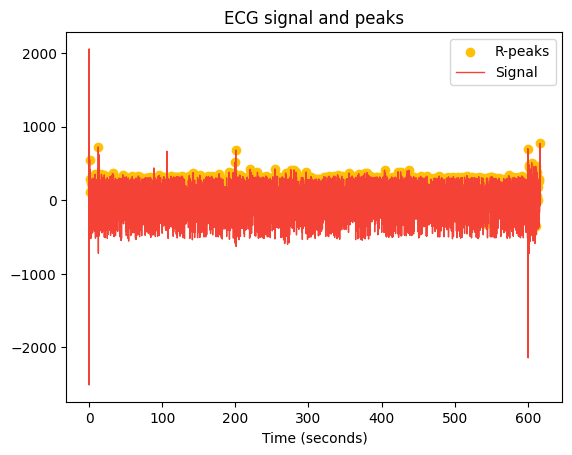

In [86]:
results = {}

np.trapezoid = np.trapz

for idx, stream in enumerate(streams):
    name = stream['info']['name'][0]
    srate = float(stream['info']['nominal_srate'][0])

    data = np.array(stream['time_series'])
    timestamps = np.array(stream['time_stamps']) - stream['time_stamps'][0]

    results[name] = compute_hr_hrv(data, 
                                   timestamps, 
                                   signal_type="ecg" if "ECG" in name.upper() else "ppg"
                                   )

for name, res in results.items():
    print(f"\n{name} HRV metrics:")
    print(res["hrv"][[
        "HRV_MeanNN",
        "HRV_SDNN",
        "HRV_RMSSD",
        "HRV_pNN50",
        "HRV_LF",
        "HRV_HF",
        "HRV_LFHF"
    ]])